# Import of Data & External Libraries

In [1]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import (LogisticRegression, 
                                  Ridge)
from sklearn.metrics import (ConfusionMatrixDisplay, 
                             f1_score,
                             precision_score,
                             recall_score,
                             mean_squared_error)
from sklearn.model_selection import (train_test_split, 
                                     KFold,  
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures, 
                                   PowerTransformer, 
                                   RobustScaler, 
                                   QuantileTransformer)

In [2]:
wine_quality = fetch_ucirepo(id=186)

In [3]:
X = wine_quality.data.features 
yq = wine_quality.data.targets
yc = wine_quality.data.original.color

The variable yq denotes the target variable quality. The variable yc denotes the target variable color.

# Classifier Model

In [4]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X,
    yc,
    test_size=0.3,
    random_state=42
)

The data is split int0 70-30 (train vs test) and a seed of 42 is selected since it is the answer to life, the universe, and everything. :D.
Note that no validation data was needed since the hyperparameter for the model was selected from CV or cross-validation.

In [5]:
pipeline_c = Pipeline([
       ('scaler', StandardScaler().set_output(transform='pandas')),
       ('model', LogisticRegression(max_iter=1000))
])

param_grid_c = {
    'model__C': np.logspace(-2, 2, 10),
}

kf_c = KFold(n_splits=5, shuffle=True, random_state=42)

gridsearch_c = GridSearchCV(pipeline_c, param_grid_c, cv=kf_c)

A pipeline object was created to chain scaling and the estimator model. The hyperparameter C (which is the inverse of the of the regularization strength) was chosen based on the estimator that gives the best score. The values are selected from a logscale between 10e-2 to 10e2 as this makes much more sense since C is the reciprocal of the regularization strength, rather than selecting from a linear scale of 1-10. 

In [29]:
gridsearch_c.fit(Xc_train, yc_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'model__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])})

The fit method was called to find the best hyperparameter from a fold of 5 and 10 choices of C (this means that 50 iterations were performed to determine the hyperparameter).

In [7]:
model_c = gridsearch_c.best_estimator_
yc_pred = model_c.predict(Xc_test)

The best estimator is then saved to the model, and then the predictions are then determined.

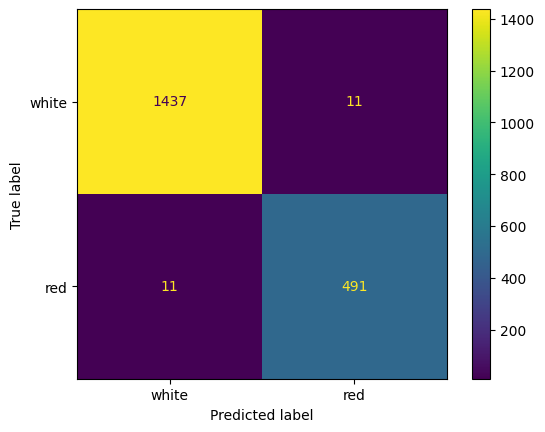

In [8]:
_ = ConfusionMatrixDisplay.from_estimator(model_c, Xc_test, yc_test, labels=['white', 'red'])

Shown is the confusion matrix where from the test data (or unseen data by the model during training), 491 was correctly predicted as red and 1437 was correctly predicted as white. However, 11 white values were incorrectly predicted as red and 11 red values were incorrectly predicted as white.

In [9]:
model_c.score(Xc_test, yc_test)

0.9887179487179487

In [10]:
gridsearch_c.best_params_

{'model__C': 4.6415888336127775}

In [11]:
for weight, col_name in zip(model_c['model'].coef_[0], Xc_test.columns):
    print(f'{col_name:<25} wt: {weight:>10.4f}')

fixed_acidity             wt:    -0.3093
volatile_acidity          wt:    -1.5327
citric_acid               wt:     0.3869
residual_sugar            wt:     4.6259
chlorides                 wt:    -0.8088
free_sulfur_dioxide       wt:    -1.2565
total_sulfur_dioxide      wt:     3.1602
density                   wt:    -4.2498
pH                        wt:    -0.0583
sulphates                 wt:    -0.6990
alcohol                   wt:    -1.5570


In [12]:
model_c['model'].coef_[0]

array([-0.30932728, -1.53271294,  0.38686576,  4.62591027, -0.80882782,
       -1.25654873,  3.16016578, -4.24979376, -0.05826294, -0.69897792,
       -1.55698654])

In [13]:
f1 = f1_score(yc_test=='white', yc_pred=='white')
rs = recall_score(yc_test=='white', yc_pred=='white')
ps = precision_score(yc_test=='white', yc_pred=='white')

print(f'f1 score = {f1:.4f} \nrecall score = {rs:.4f} \nprecision score = {ps:.4f}')

f1 score = 0.9924 
recall score = 0.9924 
precision score = 0.9924


# Regression Model

Similar process is performed for the regression model.

In [14]:
Xq_train, Xq_test, yq_train, yq_test = train_test_split(
    X,
    yq,
    test_size=0.3,
    random_state=42
)

In [15]:
pipeline_q = Pipeline([
       ('scaler', StandardScaler()),
       ('basis_func', PolynomialFeatures()),
       ('model', Ridge())
])

scalers = [
    StandardScaler(),
    RobustScaler(),
    QuantileTransformer(),
    PowerTransformer(),
]

param_grid_q = {
    'scaler': scalers,

    'basis_func__degree': [1, 2, 3],
    'basis_func__interaction_only': [True, False],

    'model__alpha': np.linspace(0, 20, 21),
}

kf_q = KFold(n_splits=5, shuffle=True, random_state=42)

gridsearch_q = GridSearchCV(
    pipeline_q, 
    param_grid_q,
    cv=kf_q, 
    scoring='neg_mean_squared_error',
    return_train_score=True
)

Here, a basis function of Polynomials is added to give a better estimate. Also, multiple scalers are searched to get a better estimator.

In [16]:
gridsearch_q.fit(Xq_train, yq_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('basis_func', PolynomialFeatures()),
                                       ('model', Ridge())]),
             param_grid={'basis_func__degree': [1, 2, 3],
                         'basis_func__interaction_only': [True, False],
                         'model__alpha': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.]),
                         'scaler': [StandardScaler(), RobustScaler(),
                                    QuantileTransformer(),
                                    PowerTransformer()]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
gridsearch_q.best_estimator_

Pipeline(steps=[('scaler', QuantileTransformer()),
                ('basis_func', PolynomialFeatures(degree=3)),
                ('model', Ridge())])

In [18]:
model_q = gridsearch_q.best_estimator_
yq_pred = model_q.predict(Xq_test)

In [19]:
gridsearch_q.best_params_

{'basis_func__degree': 3,
 'basis_func__interaction_only': False,
 'model__alpha': 1.0,
 'scaler': QuantileTransformer()}

In [20]:
params_df = pd.DataFrame(gridsearch_q.cv_results_['params'])
params_df['mean_train_score'] = gridsearch_q.cv_results_['mean_train_score']
params_df['mean_test_score'] = gridsearch_q.cv_results_['mean_test_score']
params_df

,basis_func__degree,basis_func__interaction_only,model__alpha,scaler,mean_train_score,mean_test_score
0,1,True,0.0,StandardScaler(),-0.543246,-0.547384
1,1,True,0.0,RobustScaler(),-0.543246,-0.547384
2,1,True,0.0,QuantileTransformer(),-0.553604,-0.559978
3,1,True,0.0,PowerTransformer(),-0.550518,-0.557485
4,1,True,1.0,StandardScaler(),-0.543246,-0.547379
...,...,...,...,...,...,...
499,3,False,19.0,PowerTransformer(),-0.419801,-0.693414
500,3,False,20.0,StandardScaler(),-0.416507,-3.235506
501,3,False,20.0,RobustScaler(),-0.421144,-0.562813
502,3,False,20.0,QuantileTransformer(),-0.475085,-0.495675


In [21]:
params_df[['scaler']] = params_df[['scaler']] .astype(str)

toview = params_df[(
   (params_df['basis_func__degree'] == 3)
   & (params_df['basis_func__interaction_only'] == False)
   & (params_df['scaler'] == 'QuantileTransformer()')
)]
toview

,basis_func__degree,basis_func__interaction_only,model__alpha,scaler,mean_train_score,mean_test_score
422,3,False,0.0,QuantileTransformer(),-0.409656,-0.516200
426,3,False,1.0,QuantileTransformer(),-0.437418,-0.483242
430,3,False,2.0,QuantileTransformer(),-0.445774,-0.484345
434,3,False,3.0,QuantileTransformer(),-0.450855,-0.485623
438,3,False,4.0,QuantileTransformer(),-0.454497,-0.486757
442,3,False,5.0,QuantileTransformer(),-0.457329,-0.487745
446,3,False,6.0,QuantileTransformer(),-0.459643,-0.488616
450,3,False,7.0,QuantileTransformer(),-0.461601,-0.489392
454,3,False,8.0,QuantileTransformer(),-0.463298,-0.490095
458,3,False,9.0,QuantileTransformer(),-0.464797,-0.490737


<Axes: xlabel='model__alpha', ylabel='mean_train_score'>

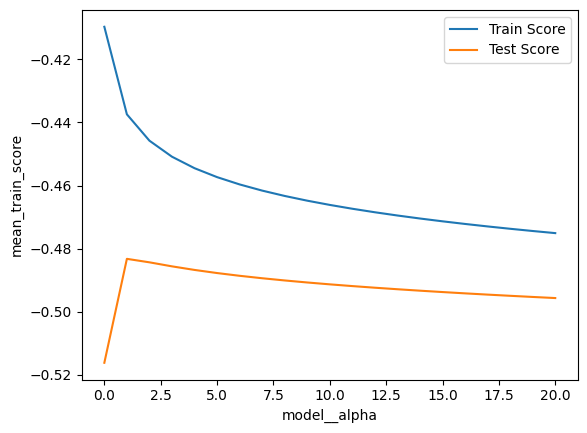

In [22]:
sns.lineplot(toview, x='model__alpha', y='mean_train_score', label='Train Score')
sns.lineplot(toview, x='model__alpha', y='mean_test_score', label='Test Score')

From the plot, it is shown that after alpha=1.0, the model is now overfitting as shown. For this case, the optimal alpha is at 1.0.

In [23]:
mse = mean_squared_error(yq_test, yq_pred)
nmse = (((yq_test - yq_pred) ** 2).sum() / ((yq_test - yq_test.mean()) ** 2).sum()).squeeze()
r2 = 1 - nmse

print(f'mean squared error = {mse:.4f}')
print(f'normalized mean squared error = {nmse:.4f}')
print(f'coefficient of determination r2 = {r2:.4f}')

mean squared error = 0.4601
normalized mean squared error = 0.6306
coefficient of determination r2 = 0.3694


Here, the R2 is kind of low but this is due to the target values being discrete (instead of being continuous).

# Quick Analysis

In [24]:
print(f'Classifier Model: \n{model_c}')
print(f'Regression Model: \n{model_q}')

Classifier Model: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=4.6415888336127775, max_iter=1000))])
Regression Model: 
Pipeline(steps=[('scaler', QuantileTransformer()),
                ('basis_func', PolynomialFeatures(degree=3)),
                ('model', Ridge())])


<Axes: >

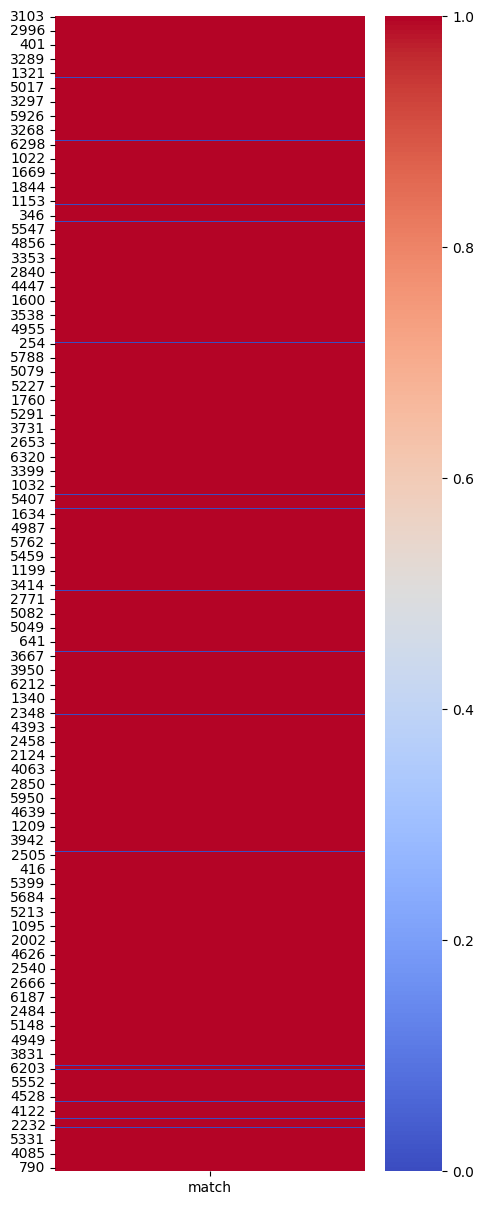

In [25]:
classifier = yc_test.to_frame().copy()
classifier['pred'] = yc_pred
classifier['match'] = (classifier['color'] == classifier['pred']).astype(int)

plt.figure(figsize=(5, 15))
sns.heatmap(classifier[['match']], cmap='coolwarm')

Shown on this heatmap is how the model predicted the test data set. Majority is red, which the model correctly predicted, and very little are blue (model predicted incorrectly).

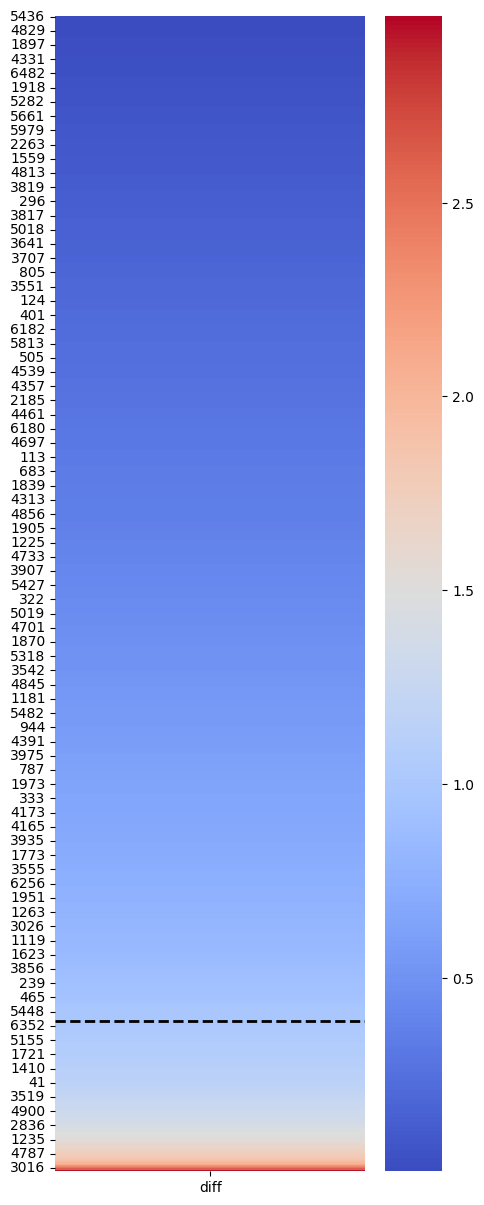

In [27]:
regression = yq_test.copy()
regression['pred'] = yq_pred
regression['diff'] = np.abs(regression['quality'] - regression['pred'])

plt.figure(figsize=(5, 15))
sorted_regression = regression[['diff']].sort_values('diff')
ax = sns.heatmap(sorted_regression, cmap='coolwarm')

threshold_index = np.argmax(sorted_regression['diff'] > 1.0)
ax.axhline(threshold_index, color='black', linestyle='--', lw=2)

The heatmap above can be interpreted as follows: The bluer the plot, the closer the prediction of the model. Since we assumed that it is a regression problem for discrete values of quality, it is very hard for the model to give a discrete predictions.

Above the dark dashed line, a threshold value is set where the test (actual data) - prediction = 1. Values above the dashed line means difference between test and prediction is less than 1.0 while those below means a difference is greater than 1.0.